<a href="https://colab.research.google.com/github/DanielDialektico/Machine-Learning/blob/main/K-medias/K_Medias_Estrellas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

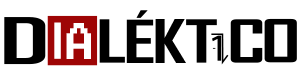

# 1. Introducción
En esta libreta se presenta un modelo de K-medias aplicado a un **conjunto de datos de estrellas** y sus propiedades físicas. El fin es crear tres agrupaciones de estrellas de acuerdo a tres de estos atributos, ejemplificando el uso del **aprendizaje no supervisado** para la estructuración de información no etiquetada. 

# 2. Carga de la información y exploración del conjunto de datos
El conjunto de datos se carga desde mi repositorio de **GitHub**. La información general sobre este conjunto de datos se especifica en el **apéndice** al final.

Antes de hacer uso del algoritmo de k-medias, se procede a hacer una efímera exploración de los datos. En este bloque se utiliza la función *head* de Pandas para imprimir los primeros cinco renglones y las 7 columnas del arreglo, esto para obtener un primer vistazo de la tabla generada.

In [1]:
#Se importan las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#Se carga el conjunto de datos desde GitHub
dataset = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Conjuntos%20de%20datos/estrellas_data_2.csv')

#Se imprime el encabezado
dataset.head()

,Magnitud aparente,Distancia,e_Plx,Índice de color,Tipo,Magnitud absoluta,Clase
0,5.99,13.73,0.58,1.318,K5III,16.678352,0
1,8.70,2.31,1.29,-0.045,B1II,15.518060,0
2,5.77,5.50,1.03,0.855,G5III,14.471813,0
3,6.72,5.26,0.74,-0.015,B7V,15.324928,1
4,8.76,13.44,1.16,0.584,G0V,19.401997,1


Con el fin de identificar los tipos de valores embebidos en los datos, y posibles valores nulos, se imprime un resumen informativo utilizando la función info() de Pandas, donde se constata que se cuentan con valores de tipo **enteros, flotantes, y objetos (solo para un atributo)**. Además, se aprecia la **ausencia de valores nulos**.

In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Magnitud aparente  3642 non-null   float64
 1   Distancia          3642 non-null   float64
 2   e_Plx              3642 non-null   float64
 3   Índice de color    3642 non-null   float64
 4   Tipo               3642 non-null   object 
 5   Magnitud absoluta  3642 non-null   float64
 6   Clase              3642 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 199.3+ KB


Con el fin de trabajar sobre un espacio desplegable en gráficas, se seleccionan tres atributos del conjunto de datos: **Distancia**, **Magnitud absoluta**, e **Índice de color**. 
Se crea una gráfica tridimensional de este subconjunto con el fin de observar su dispersión.

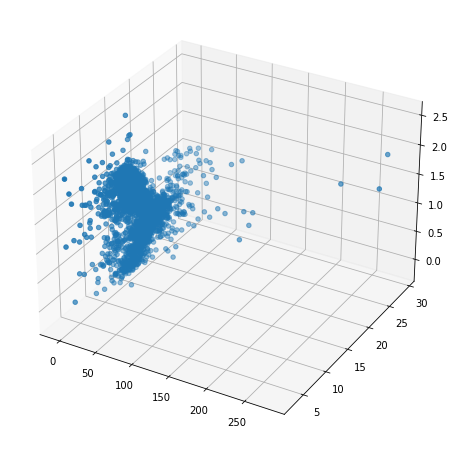

In [15]:
#Se grafican los valores de los 3 atributos seleccionados.
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset['Distancia'], dataset['Magnitud absoluta'], dataset['Índice de color'])
plt.show()

# 3. Preprocesamiento

De forma intuitiva, se pueden observar posibles **valores atípicos** (puntos alejados del mayor conglomerado). Para eliminar estos valores atípicos se procede a imprimir la distribución particular de cada atributo, además de su gráfico de caja con el fin de obtener una visualización de estos.

<Axes: >

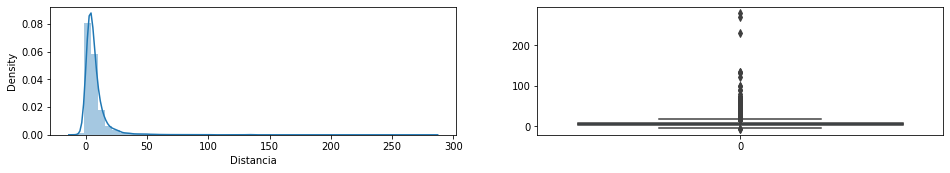

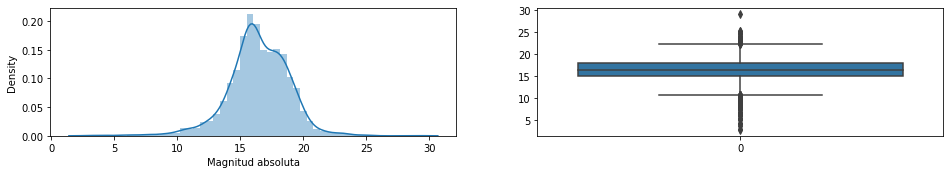

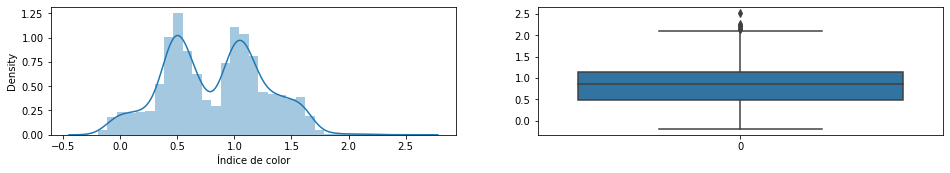

In [16]:
warnings.filterwarnings('ignore')

#Se generan las gráficas de distribución y de caja para cada variable.
plt.figure(figsize=(16,8))
plt.subplot(3,2,1)
sns.distplot(dataset['Distancia'])
plt.subplot(3,2,2)
sns.boxplot(dataset['Distancia'])
plt.figure(figsize=(16,8))
plt.subplot(3,2,3)
sns.distplot(dataset['Magnitud absoluta'])
plt.subplot(3,2,4)
sns.boxplot(dataset['Magnitud absoluta'])
plt.figure(figsize=(16,8))
plt.subplot(3,2,5)
sns.distplot(dataset['Índice de color'])
plt.subplot(3,2,6)
sns.boxplot(dataset['Índice de color'])

Debido a que se tienen distribuciones que no tienen una **distribución normal**, se procede a eliminar los valores atípicos utilizando el método por rango intercuartílico, en el que se desechan los puntos que estén por debajo y por arriba del espacio determinado por el primer y tercer cuartil. 

In [17]:
#Se crea una función que realice los cálculos de los límites inferiores y superiores del rango intercuartílico
def iqrFilter(data):
  percentile25 = dataset[data].quantile(0.25)
  percentile75 = dataset[data].quantile(0.75)
  iqr = percentile75 - percentile25
  
  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr
  
  return upper_limit,lower_limit

#Se aplica la función para la definición de los límites de cada columna
upperD,lowerD = iqrFilter('Distancia')
upperM,lowerM = iqrFilter('Magnitud absoluta')
upperI,lowerI = iqrFilter('Índice de color')  

#Se eliminan los valores que no pertenezcan al rango establecido.
dataset = dataset[dataset['Distancia'] > lowerD]
dataset = dataset[dataset['Distancia'] < upperD]
dataset = dataset[dataset['Magnitud absoluta'] > lowerM]
dataset = dataset[dataset['Magnitud absoluta'] < upperM]
dataset = dataset[dataset['Índice de color'] > lowerI]
dataset = dataset[dataset['Índice de color'] < upperI]

Una vez realizado el filtrado, se grafican de nuevo los puntos correspondientes al subconjunto seleccionando, lo cual muestra una **disminución visible de los valores atípicos**. Dado que el fin de este trabajo es aplicar un algoritmo de agrupación y ya se tiene una forma más centrada de los datos, no se aplican más pruebas y filtros para posibles residuos. 

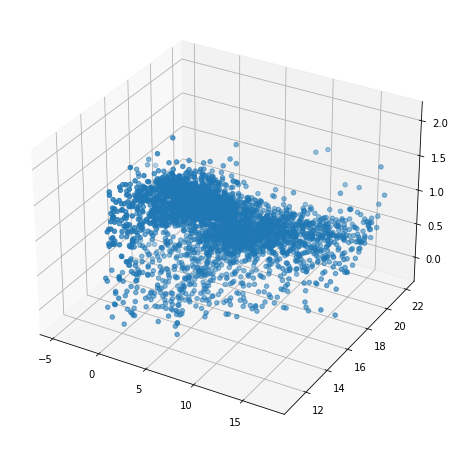

In [19]:
#Se grafican los valores de los 3 atributos seleccionados.
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset['Distancia'], dataset['Magnitud absoluta'], dataset['Índice de color'])
plt.show()

# 4. Agrupación con k-medias
Se procede a utilizar el modelo de **k-medias**, especificando un número de agrupaciones igual a tres, lo cual generará esta cantidad de conglomerados al rededor de 3 **centroides** diferentes.

In [20]:
#Se definen los atributos seleccionados como un arreglo de numpy para ser utilizados en nuestro modelo.
attributes = np.array(dataset[['Distancia', 'Magnitud absoluta', 'Índice de color']])

#Se configura el modelo con 3 agrupaciones.
kmeans = KMeans(n_clusters=3).fit(attributes)
#Se obtiene el valor de los centroides.
centroids = kmeans.cluster_centers_

Para observar los resultados, se muestran las tres agrupaciones generadas utilizando como distintivo un color diferente para cada una. 

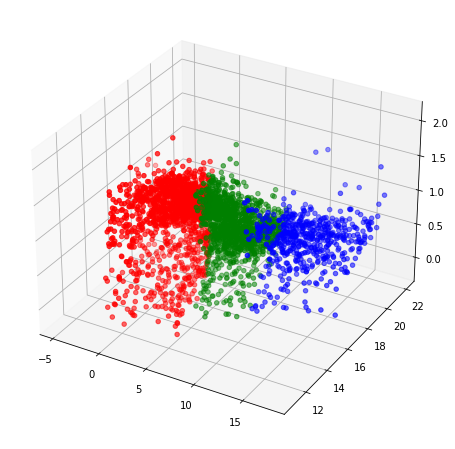

In [22]:
#Se utiliza el modelo para señalar a qué agrupación pertenece cada grupo
labels = kmeans.predict(attributes)
C = kmeans.cluster_centers_

colors=['red','green','blue']
points_colors=[]
for row in labels:
    points_colors.append(colors[row])
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset['Distancia'], dataset['Magnitud absoluta'], dataset['Índice de color'], c = points_colors)
plt.show()

Para finalizar, se grafican los puntos de nuevo, esta vez seleccionando un grosor más bajo para cada uno, y añadiendo tres círculos de cada color, los cuales representan a los **centroides** generados por el modelo.

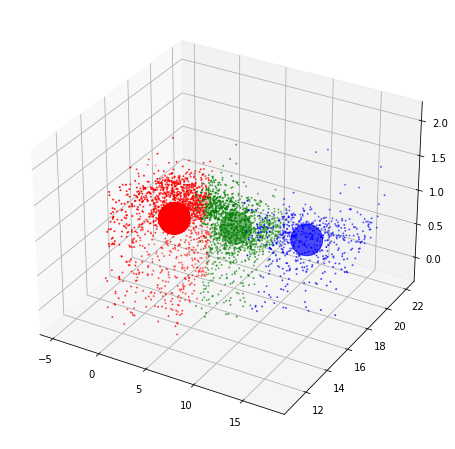

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='o', c = colors, s=1000)
ax.scatter(dataset['Distancia'], dataset['Magnitud absoluta'], dataset['Índice de color'], c = points_colors, s= 1)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='o', c = colors, s=1000)
plt.show()

Encuentra más códigos como este y las explicaciones de los modelos en https://dialektico.com/

# 5. Apéndice

### **Conjunto de datos**
El conjunto de datos  utilizado para este trabajo fue descargado de https://www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs. Consiste en una base de datos de 3,642 estrellas y sus características, obtenida de la herramienta de consulta de catálogos astronómicos [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I%2F239%2Fhip_main&-out.max=50&-out.form=HTML+Table&-out.add=_RAJ%2C_DEJ&-sort=_r&-oc.form=sexa). 
Para mayor detalles visitar la **primera URL**. 
